# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## Analysis

### Importing libraries

In [1384]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and transform data

In [1385]:
#noshow 
columns_to_use = ["pesquisa_id", "cenario_id", "turno", "partido",
                  "candidato", "cenario_descricao", "instituto",
                  "percentual", "data_pesquisa", "qtd_entrevistas",
                  "qtd_mencoes","grupo"]

HDI = [0.025, 0.5, 0.975] # quantiles

In [1386]:
def enrich_and_filter(df: pd.DataFrame) ->pd.DataFrame:
    df['qtd_mencoes'] = df.percentual * df.qtd_entrevistas / 100.0
    df['grupo'] = 'OUTROS'
    df.loc[(df.partido == 'PT'), 'grupo'] = 'LULA'
    df.loc[(df.partido.isna()), 'grupo'] = 'NULO'

    return df[columns_to_use]

In [1387]:
def get_most_recent_file() -> Path:
    data_dir = Path('../assets/data/elections2022/')
    return sorted(data_dir.glob('2022*.csv'))[-1]
print(get_most_recent_file())

../assets/data/elections2022/20220121.csv


In [1388]:
def get_most_recent_df() -> pd.DataFrame:
    return enrich_and_filter(pd.read_csv(get_most_recent_file(),
                                         sep=',',
                                         parse_dates=True,
                                         dayfirst=True)
                             )


In [1389]:
raw_df = get_most_recent_df()
raw_df.head()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_pesquisa,qtd_entrevistas,qtd_mencoes,grupo
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,2021-11-04,2000,240.0,NULO
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,2021-11-04,2000,200.0,NULO
2,9750,24567,1,PSD,Rodrigo Pacheco,cenário 1 - estimulado - 1º turno,Vox Populi,0.0,2021-11-04,2000,0.0,OUTROS
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,2021-11-04,2000,880.0,LULA
4,9750,24567,1,sem partido,Bolsonaro,cenário 1 - estimulado - 1º turno,Vox Populi,21.0,2021-11-04,2000,420.0,OUTROS


In [1390]:
def prepare_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    table_df = raw_df.pivot_table(values=['qtd_mencoes'],
                        index=['data_pesquisa', 'instituto'],
                        columns=['grupo'],
                        aggfunc=np.sum)
    table_df2 = table_df
    table2 = table_df.reset_index(col_level=1).copy()
    table2.columns = [a[1] for a in table2.columns.to_flat_index()]
    table2["TOTAL"] = table2['LULA'] + table2['NULO'] + table2['OUTROS']
    table2["mes"] = pd.to_datetime(table2['data_pesquisa']).dt.strftime('%Y_%m')
    # print(table2)
    # table3 = table2.groupby('data_pesquisa').agg({'LULA':'sum', 'NULO':'sum', 'OUTROS':'sum', 'TOTAL':'sum', 'mes':'first', 'instituto': 'first'})
    # table3 = table3.reset_index(col_level=1).copy()
    # print(table3.columns)
    # table3.columns = [a for a in table3.columns.to_flat_index()]
    
    return table2

In [1391]:
df = prepare_df(raw_df)
print(df)
### ENQUANTO PODER DATA NAO ATUALIZA (SUA PRÓPRIA PESQUISA)
### DADOS RETIRADOS DAQUI: https://bit.ly/3Ax2c93
df = df.append(pd.DataFrame({"data_pesquisa": ["2022-01-20"],
                        "mes": ["2022_01"],
                        "LULA":[1260],
                        "NULO":[360],
                        "OUTROS":[1350],
                        "TOTAL": [3000],
                        "instituto":["PoderData"]}))

df = df.append(pd.DataFrame({"data_pesquisa": ["2022-01-26"],
                        "mes": ["2022_01"],
                        "LULA":[738],
                        "NULO":[214],
                        "OUTROS":[1048],
                        "TOTAL": [2000],
                        "instituto":["Futura"]}))
df = df.append(pd.DataFrame({"data_pesquisa": ["2022-01-27"],
                        "mes": ["2022_01"],
                        "LULA":[440],
                        "NULO":[115],
                        "OUTROS":[445],
                        "TOTAL": [1000],
                        "instituto":["Futura"]}))
###
###
df

   data_pesquisa         instituto      LULA     NULO    OUTROS   TOTAL  \
0     2021-11-04        Vox Populi   880.000  440.000   660.000  1980.0   
1     2021-11-06            Quaest   990.240  288.820   783.940  2063.0   
2     2021-11-19  Paraná Pesquisas   704.980  270.680  1044.340  2020.0   
3     2021-11-20            Futura   740.000  142.000  1118.000  2000.0   
4     2021-11-24         PoderData   850.000  225.000  1400.000  2475.0   
5     2021-11-29             Atlas  1883.628  140.832  2376.540  4401.0   
6     2021-12-05            Quaest   937.020  244.440   855.540  2037.0   
7     2021-12-09    Ideia Big Data   444.000  156.000   600.000  1200.0   
8     2021-12-11               MDA   856.856  306.306   838.838  2002.0   
9     2021-12-13            Futura   758.000  170.000  1072.000  2000.0   
10    2021-12-13              Ipec   960.960  280.280   760.760  2002.0   
11    2021-12-16         Datafolha  1759.680  366.600  1539.720  3666.0   
12    2021-12-16         

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [1392]:
def simulate_prob_freq(concentration: np.array, iters=10_000, N=100_000) -> float:
    priors = stats.dirichlet.rvs(concentration, iters)
    cnt = 0
    for i in range(iters):
        votes = stats.multinomial(n=100_000, p = priors[i]).rvs()[0]
        if votes[0] > votes[2]:
            cnt += 1
    return cnt/iters * 100
# simulate_prob_freq(np.array([723, 186, 780]))
#stats.multinomial(n=100_000, p = np.array([0.45, 0.11, 0.44])).rvs()

In [1393]:
def run_prob_weekly(simulate_prob):
    prior = np.array([420,130,450])
    posterior = np.array([0,0,0])
    for obj in df.itertuples():
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior + like * 0.5
        print(obj.data_pesquisa, posterior/posterior.sum(), simulate_prob(posterior))
        prior = 1000 * posterior/posterior.sum()

# run_prob_weekly(simulate_prob_freq)

In [1394]:
mes = df.groupby("mes").sum().reset_index()
mes

,mes,LULA,NULO,OUTROS,TOTAL
0,2021_11,6048.848,1507.332,7382.820,14939.0
1,2021_12,7356.516,1973.626,7586.858,16917.0
2,2022_01,4393.000,1224.000,4818.000,10465.0


In [1395]:
def run_prob_monthly(simulate_prob):
    prior = np.array([420,130,450])
    posterior = np.array([0,0,0])
    df_by_mes = df.groupby("mes").sum().reset_index()
    for obj in df_by_mes.itertuples():
        # print(obj)
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior + like
        print(obj.mes, posterior, simulate_prob(posterior))
        prior = posterior/posterior.sum()
run_prob_monthly(simulate_prob_freq)

2021_11 [6468.848 1637.332 7832.82 ] 0.0
2021_12 [7356.9218503  1973.72872489 7587.34942481] 4.18
2022_01 [4393.43485766 1224.11666442 4818.44847792] 0.01


3.0
[1. 1. 1.]
[1. 1. 1.]


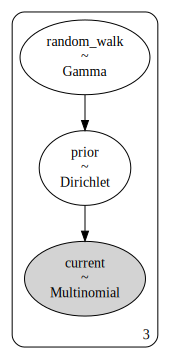

In [1396]:
def build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0) -> pm.Model:
    N = observed.sum() if not np.all(np.isnan(observed)) else 1_000
    print(N)
    print(prior)
    print(observed)
    with pm.Model() as dirichlet_model:
        rw = pm.Gamma("random_walk",
                      alpha=(rw_alpha_mult * prior),
                      beta=(rw_beta_mult * np.ones(3)), shape=(3,)
                      )
        
        previous_month_prior = pm.Dirichlet(
            "prior", a=rw, shape=(3,),
        )

        pm.Multinomial(
            "current", n=N, p=(previous_month_prior), observed=observed, shape=(3,)
        )
    
    return dirichlet_model
model = build_model(np.ones(3), np.ones(3))
pm.model_to_graphviz(model)

In [ ]:

def sampling(model: pm.Model, samples=2000, chains=2):
    with model:
        dirichlet_trace = pm.sample(samples, tune=2000, chains=chains, return_inferencedata=True, progressbar=False)
        ppc = pm.fast_sample_posterior_predictive(dirichlet_trace, 5000)
    return dirichlet_trace , ppc

def calc_prob_lula_win(model, trace, niter=30, ppc=None):
    simul = []
    if ppc:
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    for _ in tqdm(range(niter)):
        with model:
            ppc = pm.fast_sample_posterior_predictive(trace, 10000)
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    simul = np.array(simul)
    return np.quantile(simul, q=HDI)

## MONTHLY

In [ ]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()
for obj in df_by_mes.itertuples():
    for i in range(4):
        if i == 3:
            observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
            rw_alpha_mult=5.0; rw_beta_mult=1.0
        else:
            observed = np.array([np.nan, np.nan, np.nan])
            rw_alpha_mult=5.0; rw_beta_mult=1.0
        print(f">>> observed = {observed}")
        model_m = build_model(prior, observed, rw_alpha_mult=rw_alpha_mult, rw_beta_mult=rw_beta_mult)
        trace_m, ppc_m = sampling(model_m)
        posterior_m = ppc_m['current']
        prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
        qs = calc_prob_lula_win(model_m, trace_m, 20, ppc=ppc_m)
        print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
        post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
        print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
        print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
        print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [nan nan nan]
1000
[420. 130. 450.]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]


ValueError: Not enough samples to build a trace.

model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [ ]:
az.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],748.794,24.081,703.076,794.013,0.404,0.286,3568.0,3051.0,1.0
random_walk[1],213.987,11.004,194.288,235.531,0.173,0.123,4021.0,3230.0,1.0
random_walk[2],816.601,25.703,769.854,866.304,0.471,0.333,2975.0,2827.0,1.0
prior[0],0.421,0.005,0.413,0.430,0.000,0.000,3646.0,3644.0,1.0
prior[1],0.118,0.003,0.112,0.123,0.000,0.000,2855.0,2914.0,1.0
prior[2],0.461,0.005,0.452,0.469,0.000,0.000,4265.0,3555.0,1.0


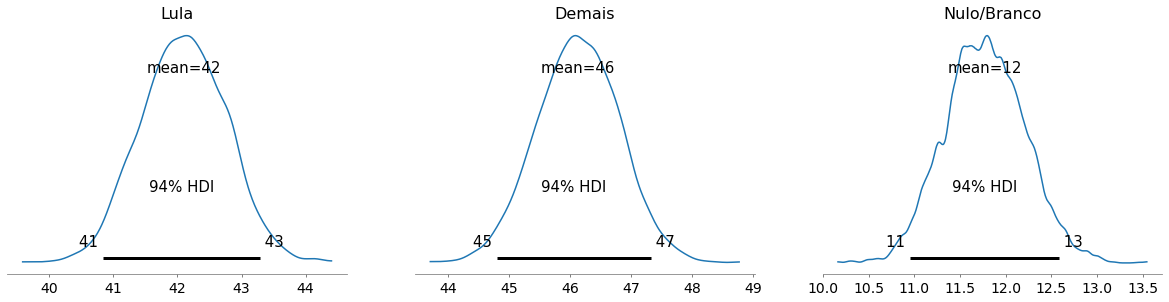

In [ ]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

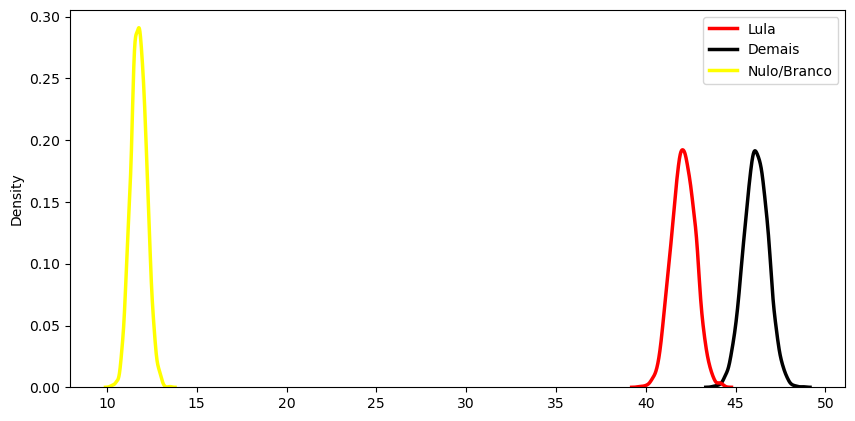

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','black','yellow'], linewidth=2.5, gridsize=500);

In [ ]:
(post_pred['Lula'] > post_pred['Demais']).mean()

0.0008

### Weekly update

In [ ]:
flat_prior = prior = np.array([400.0, 130.0, 470.0])

# df_by_mes = df.groupby("mes").sum().reset_index()
# for obj in df_by_mes.itertuples():
df_results_weekly = pd.DataFrame({})
# print(df)

for obj in df.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS])
    print(f">>> observed = {observed}")
    
    # model_w = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    model_w = build_model(prior, observed, rw_alpha_mult=2, rw_beta_mult=1.0)
    trace_w, ppc_w = sampling(model_w)
    posterior_w = ppc_w['current']
    
    prior = dirichlet.mle(posterior_w/posterior_w.sum(axis=1).reshape(-1, 1))
    
    qs = calc_prob_lula_win(model_w, trace_w, ppc=ppc_w)
    
    print(f">>> data_pesquisa={obj.data_pesquisa}, updaed_prior={prior},  qs={qs}% <<<");
    post_prob = posterior_w/posterior_w.sum(axis=1).reshape(-1, 1)
    df_results_weekly = df_results_weekly.append(pd.DataFrame({"data":[obj.data_pesquisa],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_weekly

>>> observed = [880. 440. 660.]
1980.0
[400. 130. 470.]
[880. 440. 660.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-04, updaed_prior=[505.53550543 224.33011279 445.38083772],  qs=[97.1925 97.37   97.7225]% <<<
lula= [0.4020202  0.43080808 0.45757576]
nulo= [0.16919192 0.19090909 0.21313131]
demais= [0.3520202  0.37878788 0.40656566]
>>> observed = [990.24 288.82 783.94]
2063.0
[505.53550543 224.33011279 445.38083772]
[990.24 288.82 783.94]


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'random_walk_log__': array([6.91876545, 6.10626587, 6.79207691]), 'prior_stickbreaking__': array([ 0.31306271, -0.49943688])}

Initial evaluation results:
random_walk_log__        7.15
prior_stickbreaking__    5.29
current                  -inf
Name: Log-probability of test_point, dtype: float64

model = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)

>>> data_pesquisa=2022-01-13, updaed_prior=[483.38778278 128.66210683 523.97315797],  qs=[ 9.25   9.69  10.065]% <<<
lula= [0.396633   0.42558923 0.45454545]
nulo= [0.0956229  0.11313131 0.13265993]
demais= [0.43164983 0.46127946 0.49158249]

>>> data_pesquisa=2022-01-20, updaed_prior=[896.11772754 245.53127403 967.04329633],  qs=[4.64 4.95 5.32]% <<<
lula= [0.4037037  0.42491582 0.44612795]
nulo= [0.1030303  0.11649832 0.13030303]
demais= [0.43737374 0.45858586 0.47979798]

In [ ]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(10,5));

In [ ]:
az.summary(trace_w)

In [ ]:
# fig, ax = plt.subplots(2, figsize=(10,6))
lula_w = ppc_w['current'][:,0] / ppc_w['current'].sum(axis=1) * 100
nulo_w = ppc_w['current'][:,1] / ppc_w['current'].sum(axis=1) * 100.00
demais_w = ppc_w['current'][:,2] / ppc_w['current'].sum(axis=1) * 100
# az.plot_posterior({'Lula': lula, 'Demais': demais});
# az.plot_posterior({}, ax=ax[1])

In [ ]:
# a0 = np.array([100, 299, 100])
# D0 = np.random.dirichlet(a0, 1000)
# D0
post_pred_w = pd.DataFrame({'Lula': lula_w, 'Nulo': nulo_w, 'Demais': demais_w})
az.plot_posterior(post_pred_w.to_dict(orient='list'));
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)

sns.kdeplot(data=post_pred_w, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=100);

In [ ]:
df_results_weekly

In [ ]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()
for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS])
    print(f">>> observed = {observed}")
    model_m = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)
    trace_m, ppc_m = sampling(model_m)
    posterior_m = ppc_m['current']
    prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
    qs = calc_prob_lula_win(model_m, trace_m, 50, ppc=ppc_m)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [ ]:
az.summary(trace_m)

In [ ]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','black','yellow'], linewidth=2.5, gridsize=500);

In [ ]:
(post_pred['Lula'] > post_pred['Demais']).mean()

### DAILY

In [1397]:
# for obj in df.itertuples():
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [1398]:
to_dt = lambda x: pd.to_datetime(x)
day_zero = to_dt(df.data_pesquisa).min()
n_days = int((to_dt(df.data_pesquisa).max() - day_zero) / pd.Timedelta(days=1)) + 1
poll_day = ((to_dt(df.data_pesquisa) - day_zero) / pd.Timedelta(days=1)).astype(int)
print(n_days)
print(poll_day.shape)

85
(20,)


In [1412]:
# prior = np.array([435, 110, 455]) 
to_predict = np.zeros((n_days, 3)) * np.nan

to_predict[poll_day,:] = np.array([df.LULA, df.NULO, df.OUTROS]).astype("int32").T

flat_prior = prior = np.array([400.0, 130.0, 470.0])

df_results_daily = pd.DataFrame({})
day = -1
for obj in to_predict:
    day += 1
    observed = np.array([obj[0], obj[1], obj[2]])
    print(f">>> observed = {observed}")
    
    model_d = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    trace_d, ppc_d = sampling(model_d)
    posterior_d = ppc_d['current']
    
    prior = dirichlet.mle(posterior_d/posterior_d.sum(axis=1).reshape(-1, 1))
    
    #qs = calc_prob_lula_win(model_d, trace_d, ppc=ppc_d)
    
    print(f">>> data_pesquisa={day}, updaed_prior={prior} <<<");
    post_prob = posterior_d/posterior_d.sum(axis=1).reshape(-1, 1)
    df_results_daily = df_results_daily.append(pd.DataFrame({"data":[day],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_daily



>>> observed = [880. 440. 660.]
1980.0
[400. 130. 470.]
[880. 440. 660.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


>>> data_pesquisa=0, updaed_prior=[611.62087646 235.63386253 625.45692613] <<<
lula= [0.39090909 0.41515152 0.44141414]
nulo= [0.14242424 0.15959596 0.1777904 ]
demais= [0.3989899  0.42474747 0.44949495]
>>> observed = [nan nan nan]
1000
[611.62087646 235.63386253 625.45692613]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=1, updaed_prior=[355.96786204 135.60349759 361.88222257] <<<
lula= [0.384 0.417 0.45 ]
nulo= [0.134 0.159 0.185]
demais= [0.391 0.424 0.456]
>>> observed = [990. 288. 783.]
2061.0
[355.96786204 135.60349759 361.88222257]
[990. 288. 783.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=2, updaed_prior=[652.94613708 224.59701437 603.57181426] <<<
lula= [0.41581756 0.44056283 0.46627851]
nulo= [0.13440078 0.15138282 0.17030568]
demais= [0.38136827 0.40756914 0.43231441]
>>> observed = [nan nan nan]
1000
[652.94613708 224.59701437 603.57181426]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=3, updaed_prior=[372.21820917 128.74994781 345.76812287] <<<
lula= [0.406 0.44  0.473]
nulo= [0.128 0.152 0.177]
demais= [0.376 0.408 0.441]
>>> observed = [nan nan nan]
1000
[372.21820917 128.74994781 345.76812287]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=4, updaed_prior=[340.52482854 118.47264736 319.71228524] <<<
lula= [0.403 0.437 0.471]
nulo= [0.127 0.152 0.178]
demais= [0.376 0.41  0.446]
>>> observed = [nan nan nan]
1000
[340.52482854 118.47264736 319.71228524]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=5, updaed_prior=[342.09831668 118.90343877 322.46210746] <<<
lula= [0.402 0.437 0.472]
nulo= [0.127 0.152 0.177]
demais= [0.378 0.412 0.445]
>>> observed = [nan nan nan]
1000
[342.09831668 118.90343877 322.46210746]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8838168054242419, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=6, updaed_prior=[332.7937226  116.16234588 317.52691454] <<<
lula= [0.399 0.434 0.468]
nulo= [0.127 0.151 0.178]
demais= [0.38  0.414 0.448]
>>> observed = [nan nan nan]
1000
[332.7937226  116.16234588 317.52691454]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=7, updaed_prior=[339.52491228 118.78469845 326.1201965 ] <<<
lula= [0.397 0.433 0.467]
nulo= [0.127 0.151 0.176]
demais= [0.381 0.416 0.451]
>>> observed = [nan nan nan]
1000
[339.52491228 118.78469845 326.1201965 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=8, updaed_prior=[337.35635645 120.37848962 325.44159437] <<<
lula= [0.397 0.431 0.465]
nulo= [0.129 0.153 0.18 ]
demais= [0.38  0.416 0.449]
>>> observed = [nan nan nan]
1000
[337.35635645 120.37848962 325.44159437]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=9, updaed_prior=[339.84132713 120.37062468 329.10528751] <<<
lula= [0.396    0.43     0.465025]
nulo= [0.128 0.152 0.179]
demais= [0.382 0.417 0.451]
>>> observed = [nan nan nan]
1000
[339.84132713 120.37062468 329.10528751]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=10, updaed_prior=[329.64605853 117.51143084 314.63139309] <<<
lula= [0.398 0.433 0.467]
nulo= [0.129 0.154 0.18 ]
demais= [0.378 0.413 0.448]
>>> observed = [nan nan nan]
1000
[329.64605853 117.51143084 314.63139309]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=11, updaed_prior=[339.74253212 120.26681788 320.83443895] <<<
lula= [0.4   0.435 0.471]
nulo= [0.129 0.154 0.179]
demais= [0.377 0.411 0.445]
>>> observed = [nan nan nan]
1000
[339.74253212 120.26681788 320.83443895]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=12, updaed_prior=[333.18812896 119.14775878 323.28163507] <<<
lula= [0.396 0.429 0.464]
nulo= [0.128 0.153 0.181]
demais= [0.382 0.417 0.451]
>>> observed = [nan nan nan]
1000
[333.18812896 119.14775878 323.28163507]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=13, updaed_prior=[320.08358552 112.65359071 308.50541053] <<<
lula= [0.397 0.432 0.469]
nulo= [0.127 0.152 0.179]
demais= [0.381 0.416 0.451]
>>> observed = [nan nan nan]
1000
[320.08358552 112.65359071 308.50541053]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=14, updaed_prior=[325.2246238  113.76033346 314.32652719] <<<
lula= [0.397 0.432 0.467]
nulo= [0.125975 0.151    0.177   ]
demais= [0.382 0.417 0.452]
>>> observed = [ 704.  270. 1044.]
2018.0
[325.2246238  113.76033346 314.32652719]
[ 704.  270. 1044.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=15, updaed_prior=[567.841321   205.44772699 651.5288743 ] <<<
lula= [0.37314172 0.39890981 0.42418236]
nulo= [0.12735382 0.14420218 0.16253717]
demais= [0.43111992 0.45738355 0.48364718]
>>> observed = [ 740.  142. 1118.]
2000.0
[567.841321   205.44772699 651.5288743 ]
[ 740.  142. 1118.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


>>> data_pesquisa=16, updaed_prior=[623.0122006  199.18743183 770.39191454] <<<
lula= [0.368 0.391 0.415]
nulo= [0.109  0.125  0.1415]
demais= [0.4595 0.4835 0.508 ]
>>> observed = [nan nan nan]
1000
[623.0122006  199.18743183 770.39191454]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=17, updaed_prior=[348.95496859 111.0868115  433.88551084] <<<
lula= [0.359 0.39  0.422]
nulo= [0.103 0.124 0.146]
demais= [0.453 0.485 0.518]
>>> observed = [nan nan nan]
1000
[348.95496859 111.0868115  433.88551084]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=18, updaed_prior=[316.96721187 100.97714836 396.53360646] <<<
lula= [0.357 0.389 0.423]
nulo= [0.102 0.124 0.148]
demais= [0.453    0.487    0.520025]
>>> observed = [nan nan nan]
1000
[316.96721187 100.97714836 396.53360646]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=19, updaed_prior=[305.94018949  98.11352867 381.24677833] <<<
lula= [0.356 0.39  0.423]
nulo= [0.102 0.125 0.149]
demais= [0.451 0.485 0.521]
>>> observed = [ 850.  225. 1400.]
2475.0
[305.94018949  98.11352867 381.24677833]
[ 850.  225. 1400.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=20, updaed_prior=[632.23154029 187.73957682 890.6947828 ] <<<
lula= [0.34707071 0.36929293 0.39232323]
nulo= [0.09535354 0.10949495 0.12525253]
demais= [0.49737374 0.52080808 0.54424242]
>>> observed = [nan nan nan]
1000
[632.23154029 187.73957682 890.6947828 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=21, updaed_prior=[319.37342713  94.51957839 453.56110854] <<<
lula= [0.336 0.368 0.4  ]
nulo= [0.089 0.109 0.13 ]
demais= [0.49  0.523 0.556]
>>> observed = [nan nan nan]
1000
[319.37342713  94.51957839 453.56110854]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8823984751182661, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=22, updaed_prior=[295.14117664  89.36502525 420.79782483] <<<
lula= [0.334 0.366 0.4  ]
nulo= [0.09  0.111 0.133]
demais= [0.489 0.523 0.558]
>>> observed = [nan nan nan]
1000
[295.14117664  89.36502525 420.79782483]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=23, updaed_prior=[296.22576153  89.50874996 423.36213276] <<<
lula= [0.334 0.366 0.4  ]
nulo= [0.09  0.11  0.133]
demais= [0.488 0.524 0.558]
>>> observed = [nan nan nan]
1000
[296.22576153  89.50874996 423.36213276]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=24, updaed_prior=[288.93435266  88.84893953 411.49049891] <<<
lula= [0.333    0.366    0.399025]
nulo= [0.091 0.112 0.136]
demais= [0.486  0.5215 0.556 ]
>>> observed = [1883.  140. 2376.]
4399.0
[288.93435266  88.84893953 411.49049891]
[1883.  140. 2376.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=25, updaed_prior=[1090.16637319  173.68593988 1442.95636324] <<<
lula= [0.38485451 0.40281882 0.42168675]
nulo= [0.05478518 0.06410548 0.07388043]
demais= [0.51420777 0.5330757  0.55148897]
>>> observed = [nan nan nan]
1000
[1090.16637319  173.68593988 1442.95636324]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=26, updaed_prior=[367.62808162  58.29198515 485.83455286] <<<
lula= [0.371975 0.403    0.435   ]
nulo= [0.049 0.064 0.08 ]
demais= [0.5   0.533 0.565]
>>> observed = [nan nan nan]
1000
[367.62808162  58.29198515 485.83455286]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8849459167518471, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=27, updaed_prior=[315.50721831  50.23820633 411.17988176] <<<
lula= [0.372 0.406 0.441]
nulo= [0.048 0.064 0.083]
demais= [0.494 0.529 0.564]
>>> observed = [nan nan nan]
1000
[315.50721831  50.23820633 411.17988176]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8958798664588897, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=28, updaed_prior=[329.31842238  50.51606385 421.87067418] <<<
lula= [0.378 0.411 0.444]
nulo= [0.047 0.063 0.081]
demais= [0.492 0.526 0.56 ]
>>> observed = [nan nan nan]
1000
[329.31842238  50.51606385 421.87067418]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=29, updaed_prior=[325.16795602  51.06253298 410.62667075] <<<
lula= [0.38  0.413 0.446]
nulo= [0.048 0.065 0.082]
demais= [0.488 0.522 0.556]
>>> observed = [nan nan nan]
1000
[325.16795602  51.06253298 410.62667075]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=30, updaed_prior=[321.48058958  48.99763103 411.59645455] <<<
lula= [0.377 0.411 0.446]
nulo= [0.046 0.062 0.08 ]
demais= [0.491  0.5265 0.561 ]
>>> observed = [937. 244. 855.]
2036.0
[321.48058958  48.99763103 411.59645455]
[937. 244. 855.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=31, updaed_prior=[623.60702957 122.5352231  701.76995693] <<<
lula= [0.40520629 0.43074656 0.45628684]
nulo= [0.07072692 0.08447937 0.0997053 ]
demais= [0.45874263 0.48477407 0.5108055 ]
>>> observed = [nan nan nan]
1000
[623.60702957 122.5352231  701.76995693]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=32, updaed_prior=[368.48230778  72.1639134  413.25990918] <<<
lula= [0.399 0.432 0.464]
nulo= [0.066 0.084 0.104]
demais= [0.451 0.484 0.517]
>>> observed = [nan nan nan]
1000
[368.48230778  72.1639134  413.25990918]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=33, updaed_prior=[342.47132222  64.92184184 379.9848798 ] <<<
lula= [0.4   0.435 0.47 ]
nulo= [0.064 0.082 0.102]
demais= [0.448 0.482 0.519]
>>> observed = [nan nan nan]
1000
[342.47132222  64.92184184 379.9848798 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=34, updaed_prior=[348.27338583  64.73292871 385.69214679] <<<
lula= [0.402 0.436 0.47 ]
nulo= [0.063 0.081 0.101]
demais= [0.449 0.483 0.517]
>>> observed = [444. 156. 600.]
1200.0
[348.27338583  64.73292871 385.69214679]
[444. 156. 600.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8874539117902409, but should be close to 0.8. Try to increase the number of tuning steps.


>>> data_pesquisa=35, updaed_prior=[400.55363295  90.39350954 467.0413852 ] <<<
lula= [0.3875     0.41833333 0.45083333]
nulo= [0.07666667 0.09416667 0.11333333]
demais= [0.45666667 0.4875     0.51916667]
>>> observed = [nan nan nan]
1000
[400.55363295  90.39350954 467.0413852 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=36, updaed_prior=[340.26153152  76.1205652  398.21127007] <<<
lula= [0.384 0.418 0.451]
nulo= [0.074 0.093 0.115]
demais= [0.455 0.489 0.523]
>>> observed = [856. 306. 838.]
2000.0
[340.26153152  76.1205652  398.21127007]
[856. 306. 838.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


>>> data_pesquisa=37, updaed_prior=[622.90294381 170.80507972 682.6029884 ] <<<
lula= [0.397 0.422 0.447]
nulo= [0.0995 0.1155 0.132 ]
demais= [0.4369875 0.4625    0.4885   ]
>>> observed = [nan nan nan]
1000
[622.90294381 170.80507972 682.6029884 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=38, updaed_prior=[357.98915061  98.6800603  389.90736425] <<<
lula= [0.389 0.423 0.457]
nulo= [0.096 0.116 0.138]
demais= [0.426 0.461 0.494]
>>> observed = [960. 280. 760.]
2000.0
[357.98915061  98.6800603  389.90736425]
[960. 280. 760.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=39, updaed_prior=[642.51432103 180.6220782  622.16194536] <<<
lula= [0.419  0.444  0.4705]
nulo= [0.1085 0.1245 0.1425]
demais= [0.405  0.4305 0.456 ]
>>> observed = [nan nan nan]
1000
[642.51432103 180.6220782  622.16194536]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=40, updaed_prior=[381.30200438 105.74117126 366.54774045] <<<
lula= [0.413 0.447 0.479]
nulo= [0.103 0.124 0.146]
demais= [0.397 0.429 0.463]
>>> observed = [nan nan nan]
1000
[381.30200438 105.74117126 366.54774045]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=41, updaed_prior=[351.83854496  97.75296545 336.5530476 ] <<<
lula= [0.413 0.447 0.483]
nulo= [0.101 0.124 0.148]
demais= [0.393 0.428 0.462]
>>> observed = [440. 120. 450.]
1010.0
[351.83854496  97.75296545 336.5530476 ]
[440. 120. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=42, updaed_prior=[363.17143201 100.70289187 352.77952972] <<<
lula= [0.41089109 0.44455446 0.47920792]
nulo= [0.1009901  0.12277228 0.14752475]
demais= [0.3990099  0.43168317 0.46633663]
>>> observed = [nan nan nan]
1000
[363.17143201 100.70289187 352.77952972]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=43, updaed_prior=[331.34217206  95.61908167 328.15260167] <<<
lula= [0.402 0.439 0.474]
nulo= [0.103 0.126 0.152]
demais= [0.4   0.435 0.469]
>>> observed = [nan nan nan]
1000
[331.34217206  95.61908167 328.15260167]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8848087719877982, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=44, updaed_prior=[322.18823572  92.44767915 317.44559136] <<<
lula= [0.404 0.44  0.476]
nulo= [0.102 0.126 0.151]
demais= [0.398 0.433 0.469]
>>> observed = [nan nan nan]
1000
[322.18823572  92.44767915 317.44559136]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=45, updaed_prior=[330.89426753  97.1288908  329.93633071] <<<
lula= [0.401 0.437 0.473]
nulo= [0.105 0.128 0.152]
demais= [0.4      0.436    0.470025]
>>> observed = [nan nan nan]
1000
[330.89426753  97.1288908  329.93633071]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=46, updaed_prior=[346.8676263  101.78016494 345.4320513 ] <<<
lula= [0.403 0.437 0.471]
nulo= [0.105 0.128 0.152]
demais= [0.401 0.435 0.469]
>>> observed = [1200.  330. 1470.]
3000.0
[346.8676263  101.78016494 345.4320513 ]
[1200.  330. 1470.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=47, updaed_prior=[839.14910608 239.07198898 924.26814769] <<<
lula= [0.39833333 0.419      0.44      ]
nulo= [0.105      0.11933333 0.13433333]
demais= [0.44066667 0.46166667 0.48233333]
>>> observed = [nan nan nan]
1000
[839.14910608 239.07198898 924.26814769]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=48, updaed_prior=[364.51417192 103.19088936 400.60565446] <<<
lula= [0.387 0.42  0.453]
nulo= [0.097 0.119 0.141]
demais= [0.429 0.461 0.495]
>>> observed = [nan nan nan]
1000
[364.51417192 103.19088936 400.60565446]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=49, updaed_prior=[338.46945866  97.67857815 370.20798098] <<<
lula= [0.386 0.419 0.454]
nulo= [0.099 0.121 0.144]
demais= [0.424 0.459 0.494]
>>> observed = [nan nan nan]
1000
[338.46945866  97.67857815 370.20798098]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=50, updaed_prior=[335.15583131  99.00741676 365.74743348] <<<
lula= [0.385 0.419 0.454]
nulo= [0.101 0.124 0.147]
demais= [0.423 0.458 0.491]
>>> observed = [nan nan nan]
1000
[335.15583131  99.00741676 365.74743348]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=51, updaed_prior=[320.98749993  94.42561299 350.01748681] <<<
lula= [0.384 0.42  0.455]
nulo= [0.101 0.123 0.146]
demais= [0.422 0.457 0.494]
>>> observed = [nan nan nan]
1000
[320.98749993  94.42561299 350.01748681]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=52, updaed_prior=[323.2342786   98.83760524 358.98070726] <<<
lula= [0.38  0.414 0.448]
nulo= [0.103 0.126 0.15 ]
demais= [0.425 0.46  0.495]
>>> observed = [nan nan nan]
1000
[323.2342786   98.83760524 358.98070726]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=53, updaed_prior=[306.20424496  94.77179614 342.26212151] <<<
lula= [0.377 0.412 0.447]
nulo= [0.104 0.127 0.151]
demais= [0.424 0.461 0.497]
>>> observed = [nan nan nan]
1000
[306.20424496  94.77179614 342.26212151]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=54, updaed_prior=[327.93417952  98.16770673 367.43626859] <<<
lula= [0.38  0.413 0.448]
nulo= [0.101 0.123 0.147]
demais= [0.428 0.463 0.497]
>>> observed = [nan nan nan]
1000
[327.93417952  98.16770673 367.43626859]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=55, updaed_prior=[316.08120555  95.96484938 355.81795653] <<<
lula= [0.378    0.411    0.446025]
nulo= [0.102 0.125 0.149]
demais= [0.429 0.463 0.498]
>>> observed = [nan nan nan]
1000
[316.08120555  95.96484938 355.81795653]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=56, updaed_prior=[327.65832957  99.40524427 379.85226009] <<<
lula= [0.372 0.406 0.44 ]
nulo= [0.101 0.123 0.146]
demais= [0.436    0.471    0.505025]
>>> observed = [nan nan nan]
1000
[327.65832957  99.40524427 379.85226009]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=57, updaed_prior=[323.08944762  97.94481644 373.14012196] <<<
lula= [0.373 0.407 0.441]
nulo= [0.101 0.123 0.147]
demais= [0.436 0.47  0.504]
>>> observed = [nan nan nan]
1000
[323.08944762  97.94481644 373.14012196]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=58, updaed_prior=[311.34920818  95.66199262 360.86985156] <<<
lula= [0.372 0.405 0.439]
nulo= [0.102 0.124 0.149]
demais= [0.435975 0.47     0.505   ]
>>> observed = [nan nan nan]
1000
[311.34920818  95.66199262 360.86985156]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=59, updaed_prior=[313.87071681  95.45460976 363.44020132] <<<
lula= [0.371 0.407 0.44 ]
nulo= [0.101 0.123 0.147]
demais= [0.434 0.47  0.506]
>>> observed = [nan nan nan]
1000
[313.87071681  95.45460976 363.44020132]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=60, updaed_prior=[317.70958732  95.91699422 375.29754303] <<<
lula= [0.369 0.403 0.436]
nulo= [0.099 0.121 0.145]
demais= [0.440975 0.475    0.511   ]
>>> observed = [nan nan nan]
1000
[317.70958732  95.91699422 375.29754303]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=61, updaed_prior=[314.20661572  92.18316006 375.04437786] <<<
lula= [0.368 0.402 0.436]
nulo= [0.096 0.118 0.141]
demais= [0.445 0.48  0.515]
>>> observed = [nan nan nan]
1000
[314.20661572  92.18316006 375.04437786]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=62, updaed_prior=[311.77174389  91.97306585 372.65523322] <<<
lula= [0.368 0.401 0.436]
nulo= [0.096 0.118 0.143]
demais= [0.445 0.48  0.513]
>>> observed = [nan nan nan]
1000
[311.77174389  91.97306585 372.65523322]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=63, updaed_prior=[321.92839118  94.33529138 384.40011422] <<<
lula= [0.368 0.402 0.437]
nulo= [0.096 0.118 0.14 ]
demais= [0.445 0.48  0.514]
>>> observed = [nan nan nan]
1000
[321.92839118  94.33529138 384.40011422]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=64, updaed_prior=[317.00789969  94.10844495 384.21267486] <<<
lula= [0.365 0.399 0.433]
nulo= [0.096975 0.118    0.141   ]
demais= [0.448 0.483 0.518]
>>> observed = [nan nan nan]
1000
[317.00789969  94.10844495 384.21267486]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=65, updaed_prior=[296.71029907  90.97830782 359.6934935 ] <<<
lula= [0.363 0.397 0.432]
nulo= [0.098 0.121 0.146]
demais= [0.446 0.481 0.517]
>>> observed = [900. 240. 820.]
1960.0
[296.71029907  90.97830782 359.6934935 ]
[900. 240. 820.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8788585270442659, but should be close to 0.8. Try to increase the number of tuning steps.


>>> data_pesquisa=66, updaed_prior=[595.1716458  172.30627998 644.70630179] <<<
lula= [0.39539541 0.42142857 0.44744898]
nulo= [0.10510204 0.12193878 0.13928571]
demais= [0.43061224 0.45663265 0.48265306]
>>> observed = [nan nan nan]
1000
[595.1716458  172.30627998 644.70630179]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=67, updaed_prior=[363.81461434 105.41003694 395.23847534] <<<
lula= [0.388 0.421 0.453]
nulo= [0.101 0.122 0.144]
demais= [0.423 0.457 0.49 ]
>>> observed = [nan nan nan]
1000
[363.81461434 105.41003694 395.23847534]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=68, updaed_prior=[336.72873841  95.69293389 367.53170534] <<<
lula= [0.388 0.421 0.455]
nulo= [0.098 0.119 0.143]
demais= [0.426 0.459 0.493]
>>> observed = [440. 130. 450.]
1020.0
[336.72873841  95.69293389 367.53170534]
[440. 130. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


>>> data_pesquisa=69, updaed_prior=[348.66046566 100.02709806 374.91249434] <<<
lula= [0.39019608 0.42254902 0.45784314]
nulo= [0.1        0.12156863 0.14411765]
demais= [0.41960784 0.45588235 0.48921569]
>>> observed = [615. 165. 705.]
1485.0
[348.66046566 100.02709806 374.91249434]
[615. 165. 705.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=70, updaed_prior=[477.59154985 134.62549642 523.95794067] <<<
lula= [0.39191919 0.42020202 0.44983165]
nulo= [0.1003367  0.11851852 0.13737374]
demais= [0.43232323 0.46127946 0.48956229]
>>> observed = [nan nan nan]
1000
[477.59154985 134.62549642 523.95794067]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=71, updaed_prior=[348.52616828  98.41549808 377.72647147] <<<
lula= [0.389 0.423 0.456]
nulo= [0.097 0.119 0.142]
demais= [0.423 0.458 0.492]
>>> observed = [nan nan nan]
1000
[348.52616828  98.41549808 377.72647147]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=72, updaed_prior=[344.24608233  96.07797809 376.57263897] <<<
lula= [0.388 0.421 0.457]
nulo= [0.096 0.117 0.141]
demais= [0.428 0.461 0.494]
>>> observed = [nan nan nan]
1000
[344.24608233  96.07797809 376.57263897]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=73, updaed_prior=[326.64635208  89.26794141 356.82911264] <<<
lula= [0.387 0.423 0.458]
nulo= [0.094 0.115 0.138]
demais= [0.427 0.462 0.499]
>>> observed = [nan nan nan]
1000
[326.64635208  89.26794141 356.82911264]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=74, updaed_prior=[325.92978009  90.14751831 356.32202375] <<<
lula= [0.387975 0.422    0.456   ]
nulo= [0.094 0.117 0.14 ]
demais= [0.426 0.461 0.496]
>>> observed = [nan nan nan]
1000
[325.92978009  90.14751831 356.32202375]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=75, updaed_prior=[319.12725979  89.32484868 348.05684432] <<<
lula= [0.388 0.422 0.456]
nulo= [0.095 0.118 0.142]
demais= [0.425 0.46  0.496]
>>> observed = [nan nan nan]
1000
[319.12725979  89.32484868 348.05684432]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=76, updaed_prior=[330.47503148  88.6972169  353.7401393 ] <<<
lula= [0.393 0.427 0.464]
nulo= [0.093 0.115 0.138]
demais= [0.423 0.458 0.493]
>>> observed = [1260.  360. 1350.]
2970.0
[330.47503148  88.6972169  353.7401393 ]
[1260.  360. 1350.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=77, updaed_prior=[863.92614989 239.47409579 925.11475368] <<<
lula= [0.4043771  0.42626263 0.44680135]
nulo= [0.1043771  0.11784512 0.13233165]
demais= [0.43468013 0.45589226 0.4781229 ]
>>> observed = [nan nan nan]
1000
[863.92614989 239.47409579 925.11475368]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=78, updaed_prior=[383.82531005 106.99448705 413.46526922] <<<
lula= [0.391975 0.425    0.456   ]
nulo= [0.098 0.118 0.14 ]
demais= [0.425 0.457 0.49 ]
>>> observed = [nan nan nan]
1000
[383.82531005 106.99448705 413.46526922]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=79, updaed_prior=[341.85564887  94.94386208 366.41924142] <<<
lula= [0.391975 0.426    0.461   ]
nulo= [0.096 0.118 0.141]
demais= [0.422 0.456 0.491]
>>> observed = [nan nan nan]
1000
[341.85564887  94.94386208 366.41924142]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=80, updaed_prior=[332.29283431  91.69128824 354.00508367] <<<
lula= [0.392 0.427 0.462]
nulo= [0.095 0.117 0.141]
demais= [0.42  0.455 0.49 ]
>>> observed = [nan nan nan]
1000
[332.29283431  91.69128824 354.00508367]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=81, updaed_prior=[318.83955272  87.87431788 344.62920156] <<<
lula= [0.389 0.424 0.46 ]
nulo= [0.095 0.117 0.14 ]
demais= [0.423 0.459 0.493]
>>> observed = [nan nan nan]
1000
[318.83955272  87.87431788 344.62920156]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=82, updaed_prior=[325.49638369  90.03223963 354.40342678] <<<
lula= [0.387 0.423 0.458]
nulo= [0.095 0.117 0.139]
demais= [0.425 0.46  0.496]
>>> observed = [ 738.  214. 1048.]
2000.0
[325.49638369  90.03223963 354.40342678]
[ 738.  214. 1048.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=83, updaed_prior=[572.72200663 161.2507102  692.05472616] <<<
lula= [0.3755 0.402  0.427 ]
nulo= [0.0975 0.113  0.1295]
demais= [0.459  0.4855 0.5115]
>>> observed = [440. 115. 445.]
1000.0
[572.72200663 161.2507102  692.05472616]
[440. 115. 445.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


>>> data_pesquisa=84, updaed_prior=[353.92953482  98.52912214 416.35742351] <<<
lula= [0.375 0.407 0.44 ]
nulo= [0.093 0.113 0.134]
demais= [0.446 0.479 0.513]


,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,0,0.390909,0.415152,0.441414,0.398990,0.424747,0.449495
0,1,0.384000,0.417000,0.450000,0.391000,0.424000,0.456000
0,2,0.415818,0.440563,0.466279,0.381368,0.407569,0.432314
0,3,0.406000,0.440000,0.473000,0.376000,0.408000,0.441000
0,4,0.403000,0.437000,0.471000,0.376000,0.410000,0.446000
0,5,0.402000,0.437000,0.472000,0.378000,0.412000,0.445000
0,6,0.399000,0.434000,0.468000,0.380000,0.414000,0.448000
0,7,0.397000,0.433000,0.467000,0.381000,0.416000,0.451000
0,8,0.397000,0.431000,0.465000,0.380000,0.416000,0.449000
0,9,0.396000,0.430000,0.465025,0.382000,0.417000,0.451000


In [1413]:
trace_d, ppc_d = sampling(model_d)
posterior_d = ppc_d['current']
az.summary(trace_d)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],5774.467,90.666,5599.835,5940.507,1.574,1.114,3320.0,2948.0,1.0
random_walk[1],1614.560,48.585,1527.317,1707.445,1.040,0.736,2162.0,2476.0,1.0
random_walk[2],6870.338,101.760,6681.668,7066.390,1.642,1.161,3846.0,2527.0,1.0
prior[0],0.407,0.006,0.395,0.419,0.000,0.000,2798.0,3000.0,1.0
prior[1],0.113,0.004,0.106,0.121,0.000,0.000,1971.0,2387.0,1.0
prior[2],0.479,0.006,0.468,0.491,0.000,0.000,3835.0,3287.0,1.0


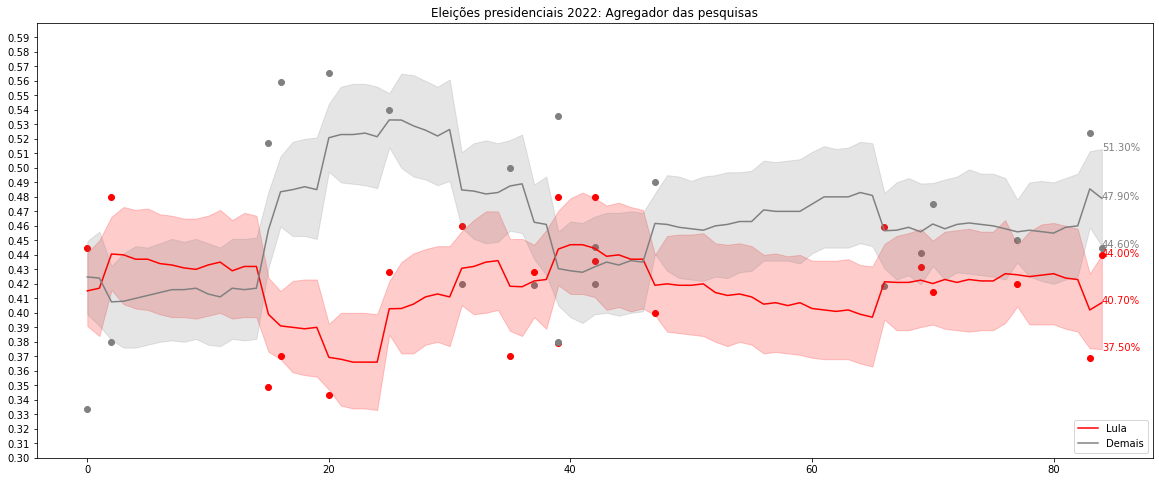

In [1414]:
dfrw = df_results_daily.groupby('data').mean().reset_index(col_level=1).copy()
dfrw.columns = dfrw.columns.to_flat_index()
# print(dfrw)
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))

plt.scatter(dfrw.data[poll_day], df.LULA/df.TOTAL, color='red')
plt.scatter(dfrw.data[poll_day], df["OUTROS"]/df["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red', label="Lula")
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray', label="Demais")
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')
plt.legend(loc='lower right')
plt.show()

## Playground

In [ ]:
import math
1 - stats.norm.cdf(0, loc=-1, scale=math.sqrt(5))

In [ ]:
import scipy as sp
true_p = sp.stats.dirichlet(6.0 * np.array([0.45, 0.3, 0.15, 0.9, 0.01])).rvs(size=10)
observed = np.vstack([sp.stats.multinomial(n=50, p=p_i).rvs() for p_i in true_p])



In [ ]:
observed.sum(axis=1)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
import plotly.io as pio
# Default is plotly_mimetype+notebook, but jekyll fails to parse plotly_mimetype.
pio.renderers.default = 'notebook_connected'

# Inject the missing require.js dependency.
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))
import plotly.express as px

# df_gm = px.data.gapminder()
# px.scatter(df_gm, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
#            size="pop", color="continent", hover_name="country",
#            log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])


In [ ]:
# hide_input
# This cell is required for the export to HTML to work.


In [ ]:
observed_prior = np.array([7356., 1973., 7578.])
prior = []
N = 4000
for it in range(N):
    b = stats.beta.rvs(a=5, b=1, size=3)
    # print(b)
    # print(observed_prior * b)
    diric = stats.dirichlet.rvs(observed_prior * b,)
    # print(diric[0])
    prior.append(diric[0])
prior = np.array(prior)
print(prior[:4])

In [ ]:

print((prior[:,0] > prior[:,2]).mean())
print(prior.shape)


In [ ]:
posterior = []
for it in range(N):
    mn = stats.multinomial.rvs(n=3000, p=[1340/3000, 370/3000, 1290/3000])
    posterior.append(mn * prior[it])
posterior = np.array(posterior)



In [ ]:
post = posterior#/posterior.sum(axis=1).reshape(4000,1)
print(post.sum(axis=1))
print(post[:10, 0])
print(post[:10, 2])

In [ ]:
lula = post[:, 0]
others = post[:, 2]
print((lula > others).mean())

In [ ]:
simul = []
for it in range(N):
    idx = np.random.choice(N,1)[0]
    #print(idx)
    #print(post[idx])
    dir2 = stats.dirichlet.rvs(post[idx])[0]
    simul.append(dir2)
dir2 = np.array(simul)

In [ ]:
dir2

In [ ]:
lula = dir2[:, 0]
others = dir2[:, 2]
print((lula > others).mean())

In [ ]:
np.arange(10)

In [ ]:
np.linspace(0,1, 101)

In [ ]:
x = np.arange(5,10)

In [ ]:
np.concatenate([[x[0] - 5], x, [x[-1] + 5]])

In [ ]:
1.96 * np.sqrt((0.5**2)/3000)

In [ ]:
1./(1./0.01789 + 1./0.0200)

In [ ]:
1/100

In [ ]:
1/(1./0.01789 + 1./0.0200)

In [ ]:
X = np.arange(1, 100)
X.mean(), X.std()

(50.0, 28.577380332470412)

20.84765670404281 3.972107376898167


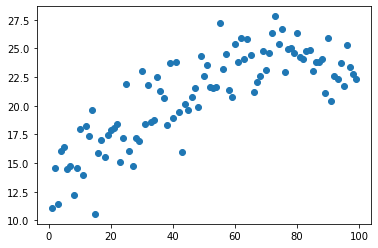

In [ ]:
Y = 12*(np.sin(X/50) + 1) + np.random.normal(0, 2, X.size)
print(Y.mean(), Y.std())
plt.scatter(X, Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grw]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


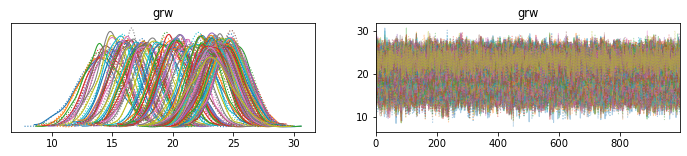

In [1465]:
with pm.Model() as grw:
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=1.0, shape=X.size)
    
    observed = pm.Normal('observed', mu=grw, sigma=Y.std(), observed=Y)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, 
                          return_inferencedata=True)
    summary = az.summary(trace) # used below
    az.plot_trace(trace)  


In [1466]:
trace.posterior.grw.mean(axis=0).mean(axis=0)

<xarray.DataArray 'grw' (grw_dim_0: 99)>
array([13.82043227, 14.00121798, 14.1472669 , 14.43803359, 14.62661047,
       14.72456967, 14.80760064, 14.90605221, 15.20440467, 15.54847977,
       15.71434149, 15.99780603, 16.18202919, 16.24339762, 16.07068512,
       16.26142406, 16.45930964, 16.63268857, 16.91105654, 17.14917462,
       17.31123624, 17.4101661 , 17.47209195, 17.65397514, 17.88027114,
       17.82262038, 17.90821868, 18.20028649, 18.55898271, 19.03732348,
       19.2543919 , 19.53061492, 19.65546771, 19.84778983, 20.13887024,
       20.26519561, 20.30506154, 20.36363076, 20.50805058, 20.46604987,
       20.47428319, 20.32018959, 20.25302285, 20.43297593, 20.64977235,
       20.96750839, 21.27660647, 21.53568954, 21.90097301, 22.11926277,
       22.30760848, 22.4476053 , 22.64104038, 22.86700024, 23.16339079,
       23.21569273, 23.29880402, 23.23788804, 23.37505848, 23.64059153,
       23.82082576, 23.93769974, 23.99692761, 23.99705991, 23.90318106,
       23.78402635, 23.80589903, 23.91971679, 24.17068696, 24.35867973,
       24.64136925, 24.88984426, 25.04957028, 25.02512985, 25.01388584,
       24.84469392, 24.80783007, 24.77530544, 24.72279329, 24.68346687,
       24.50647669, 24.38322772, 24.27446272, 24.1360388 , 23.92622531,
       23.80066778, 23.66680114, 23.51747137, 23.33388411, 23.30718028,
       23.08729731, 23.08751794, 23.04040865, 23.062705  , 23.05726432,
       23.17947386, 23.12931123, 23.07171564, 23.05539212])
Coordinates:
  * grw_dim_0  (grw_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98

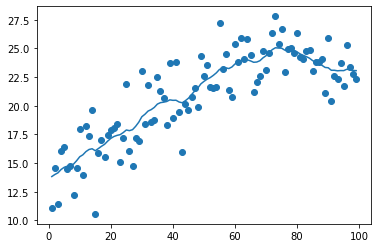

In [1467]:
plt.scatter(X, Y)
plt.plot(X, trace.posterior.grw.mean(axis=0).mean(axis=0))

In [1468]:
# az.summary(trace)
trace.posterior.grw.mean(axis=0).shape

(1000, 99)

In [1469]:
qs = np.quantile(trace.posterior.grw.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)


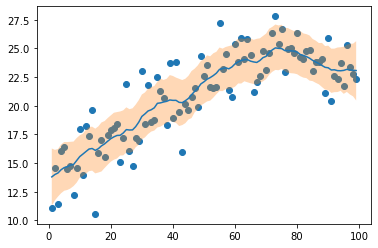

In [1470]:
plt.scatter(X, Y)
plt.plot(X, qs[1])
plt.fill_between(x=X,y1=qs[0], y2=qs[2], alpha=0.3)

In [1471]:
df.shape

(20, 7)

In [1472]:
YL = raw_df.query("partido == 'PT' ")["percentual"]
YL = YL.append(to_append=pd.Series([42, 36.9, 44]))
#YL = YL.append(to_append=pd.Series([np.nan]*10))

XL = np.arange(YL.size)
# XL = df_results_weekly.data
# YL = YL.append(to_append=pd.Series([42]))
# YL[10:13]=np.nan

In [1473]:
measurement_error = np.sqrt((50*50)/1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, grw, inov]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 51 seconds.
The acceptance probability does not match the target. It is 0.6195254789847159, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


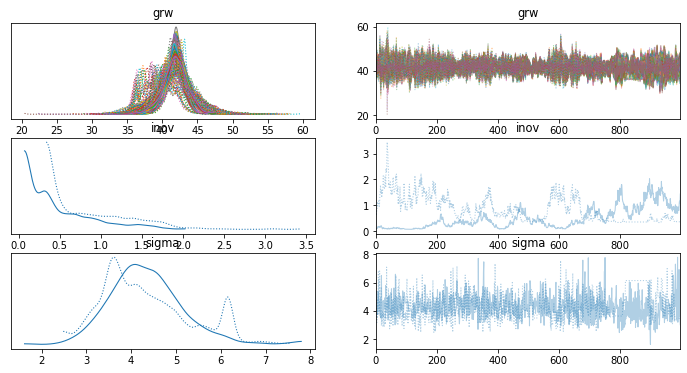

In [1500]:
with pm.Model() as grw:
    
    inov = pm.HalfNormal('inov', sigma=1)
    
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=inov, shape=n_days)
    
    sigma = pm.HalfCauchy("sigma", beta=10)
    
    observed = pm.Normal('observed', mu=grw[poll_day], sigma=sigma, observed=YL)
    
    trace = pm.sample(1000, tune=500, progressbar=True, 
                          return_inferencedata=True)
    summary = az.summary(trace) # used below
    az.plot_trace(trace)  


In [1501]:
trace.posterior.grw.mean(axis=0).shape

(1000, 85)

In [1502]:
poll_day.values

array([ 0,  2, 15, 16, 20, 25, 31, 35, 37, 39, 39, 42, 42, 47, 66, 69, 70,
       77, 83, 84])

In [1503]:
datas = []
print(n_days)
for d in range(n_days):
    datas.append((pd.to_datetime(df.data_pesquisa).min() + pd.Timedelta(days=d)).strftime("%Y-%m-%d"))

85


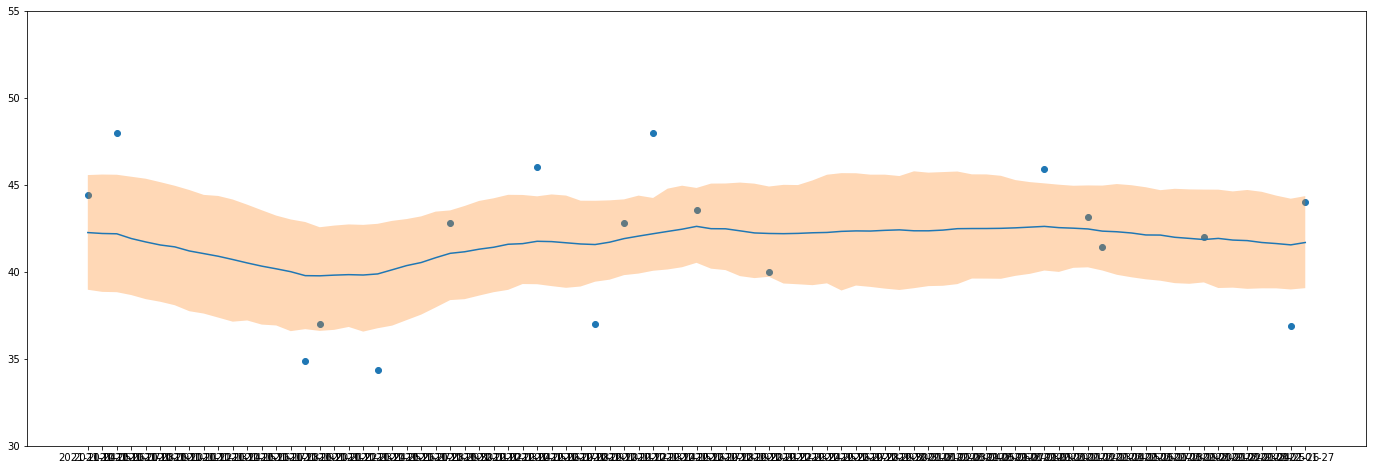

In [1504]:
qs = np.quantile(trace.posterior.grw.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
# print(qs[0].shape)
pdv = poll_day.values
df_rand_walk = pd.DataFrame({'data_pesquisa': df.data_pesquisa, 'LULA': 100.0 * df.LULA/df.TOTAL, 'LB': qs[0][pdv], 'M':qs[1][pdv], 'UB':qs[2][pdv]})
# print(df_rand_walk)
table_rw = df_rand_walk.groupby('data_pesquisa').mean().reset_index(col_level=1).copy()
table_rw.columns = table_rw.columns.to_flat_index()
# print(table_rw)

plt.figure(figsize=(24,8))
plt.ylim(30, 55)
ph = np.zeros(n_days) * np.nan
ph[poll_day.values] = df_rand_walk.LULA
plt.scatter(datas, ph)
plt.plot(datas, qs[1])
plt.fill_between(x=datas, y1=qs[0], y2=qs[2], alpha=0.3)

In [1438]:
df_results_weekly['LULA'] = df.LULA.values
df_results_weekly['DEMAIS'] = df.OUTROS.values
df_results_weekly['TOTAL'] = df.TOTAL.values

df_results_weekly

ValueError: Length of values (20) does not match length of index (1)

In [ ]:
# YL = YL/100.0
# dfrw.data.values[-1]


In [ ]:
dfrw = df_results_weekly.groupby('data').mean().reset_index(col_level=1).copy()
dfrw.columns = dfrw.columns.to_flat_index()
# print(dfrw)
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))

plt.scatter(df.data_pesquisa, df.LULA/df.TOTAL, color='red')
plt.scatter(df.data_pesquisa, df["OUTROS"]/df["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red', label="Lula")
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray', label="Demais")
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')
plt.legend(loc='lower right')
plt.show()

### Machine Learning

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
to_dt = lambda x: pd.to_datetime(x)
day_zero = to_dt(df.data_pesquisa).min()
n_days = int((to_dt(df.data_pesquisa).max() - day_zero) / pd.Timedelta(days=1)) + 1
poll_day = ((to_dt(df.data_pesquisa) - day_zero) / pd.Timedelta(days=1)).astype(int)

In [ ]:
print(f'{day_zero=}')
print(f'{n_days=}')
print(f'{poll_day.values=}')

day_zero=Timestamp('2021-11-04 00:00:00')
n_days=85
poll_day.values=array([ 0,  2, 15, 16, 20, 25, 31, 35, 37, 39, 39, 42, 42, 47, 66, 69, 70,
       77, 83, 84])


In [ ]:
svr = SVR(kernel='rbf', C=50, gamma=1e-3, epsilon=0.1)
Y = 100* df.LULA/df.TOTAL
print(poll_day.shape, Y.shape)

(20,) (20,)


In [ ]:
svr.fit(poll_day.values.reshape(-1,1), Y, sample_weight=df.TOTAL/2000.0)

SVR(C=50, gamma=0.001)

In [ ]:
pred_lula = svr.predict(np.arange(0,85).reshape(-1,1))

In [ ]:
pred_lula

array([44.34470019, 43.64676922, 42.96321775, 42.29971233, 41.66172563,
       41.05446302, 40.48279224, 39.95117752, 39.46361916, 39.02360001,
       38.63403959, 38.29725683, 38.01494222, 37.78813978, 37.61723931,
       37.501979  , 37.44145839, 37.4341614 , 37.47798902, 37.57030087,
       37.70796499, 37.88741469, 38.10471146, 38.35561256, 38.63564214,
       38.94016427, 39.26445668, 39.60378366, 39.95346683, 40.30895242,
       40.6658739 , 41.0201089 , 41.36782935, 41.70554429, 42.03013454,
       42.33887901, 42.62947222, 42.90003332, 43.14910647, 43.37565314,
       43.5790368 , 43.75900069, 43.9156394 , 44.04936528, 44.16087067,
       44.25108694, 44.3211414 , 44.37231337, 44.40599022, 44.42362452,
       44.42669328, 44.41666006, 44.39494068, 44.36287322, 44.32169274,
       44.27251111, 44.21630209, 44.15389176, 44.08595422, 44.01301239,
       43.93544348, 43.85348882, 43.76726749, 43.67679306, 43.581993  ,
       43.48272993, 43.37882399, 43.27007577, 43.15628907, 43.03

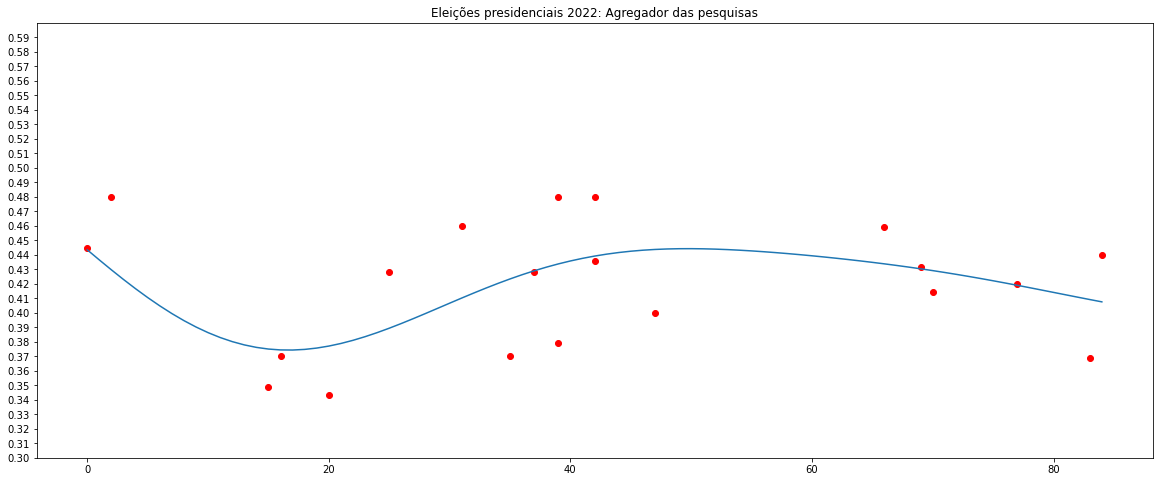

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))
plt.scatter(poll_day, df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,85), pred_lula/100.)

In [ ]:
from sklearn.model_selection import GridSearchCV
svr = SVR()
parameters = {'C': np.arange(500, 2000, 50), 'gamma': np.arange(1e-05, 1.1e-3, 1e-5)}

In [ ]:
clf = GridSearchCV(svr, parameters, scoring='neg_mean_squared_error', cv=poll_day.values.size//1, verbose=1)
clf.fit(poll_day.values.reshape(-1,1), Y, sample_weight=np.sqrt(df.TOTAL/df.TOTAL.min()))

Fitting 20 folds for each of 3270 candidates, totalling 65400 fits


GridSearchCV(cv=20, estimator=SVR(C=1600, gamma=7.000000000000001e-05),
             param_grid={'C': array([ 500,  550,  600,  650,  700,  750,  800,  850,  900,  950, 1000,
       1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
       1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950]),
                         'gamma': array([1.00e-05, 2.00e-05, 3.00e-05, 4.00e-05, 5.00e-05, 6.00e-05,
       7.00e-05, 8.00e-05, 9.00e-05, 1.00e-04, 1.10e-04, 1....
       7.30e-04, 7.40e-04, 7.50e-04, 7.60e-04, 7.70e-04, 7.80e-04,
       7.90e-04, 8.00e-04, 8.10e-04, 8.20e-04, 8.30e-04, 8.40e-04,
       8.50e-04, 8.60e-04, 8.70e-04, 8.80e-04, 8.90e-04, 9.00e-04,
       9.10e-04, 9.20e-04, 9.30e-04, 9.40e-04, 9.50e-04, 9.60e-04,
       9.70e-04, 9.80e-04, 9.90e-04, 1.00e-03, 1.01e-03, 1.02e-03,
       1.03e-03, 1.04e-03, 1.05e-03, 1.06e-03, 1.07e-03, 1.08e-03,
       1.09e-03])},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
clf.best_params_

{'C': 1400, 'gamma': 0.0001}

In [ ]:
np.arange(1e-3, 1e-1, 5e-3)

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096])

In [ ]:
pred_lula = clf.best_estimator_.predict(np.arange(0,n_days).reshape(-1,1))

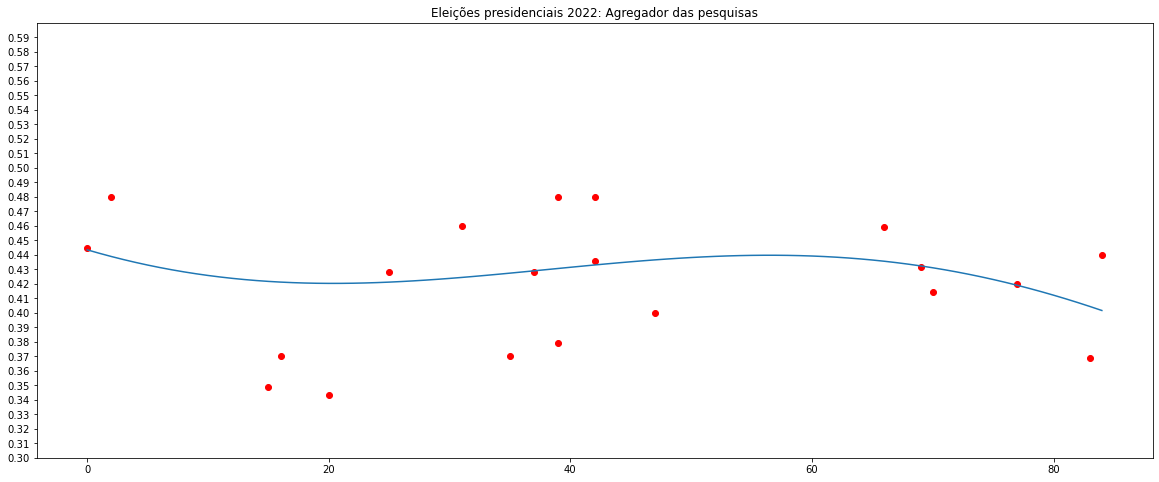

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))
plt.scatter(poll_day, df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,n_days), pred_lula/100.)

In [ ]:
res = []
svr = SVR(C=1600, gamma=7.000000000000001e-05)
x_pred = np.arange(0, n_days)
a = np.arange(0, poll_day.values.size)
sw = df.TOTAL/df.TOTAL.min()
for _ in range(10_000):
    idx = np.random.choice(a, size=poll_day.values.size)
    svr.fit(poll_day.iloc[idx].values.reshape(-1,1), Y.iloc[idx].values, sample_weight=sw.iloc[idx].values)
    res.append(svr.predict(x_pred.reshape(-1,1)))
res = np.array(res)
print(res.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
qs = np.quantile(res, q=[0.025, 0.2, 0.5, 0.8, 0.975], axis=0)
qs.shape

IndexError: index -1 is out of bounds for axis 0 with size 0

Text(84, 35.95865366414718, '36.21%')

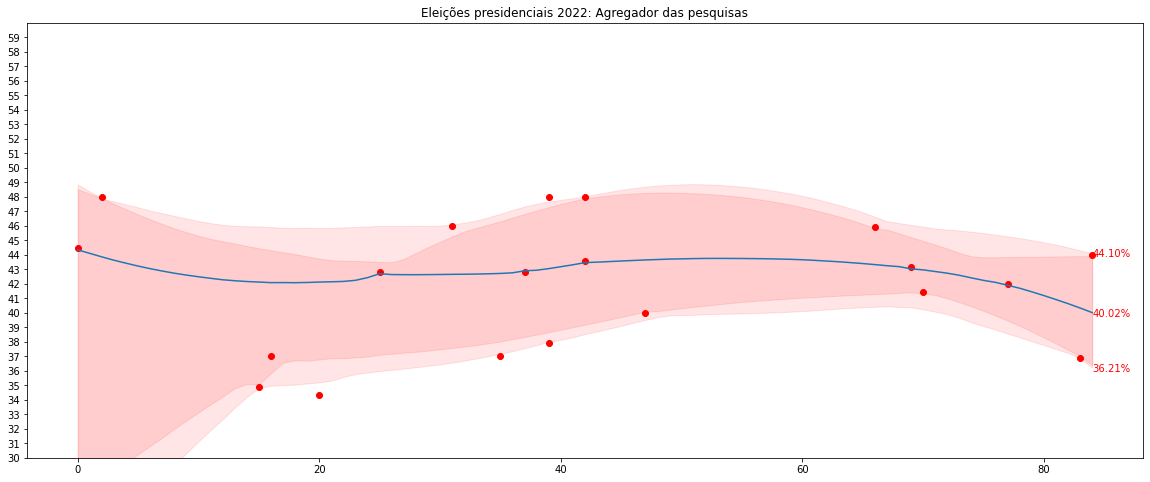

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(30, 60)
plt.yticks(np.arange(30, 60, 1))
plt.scatter(poll_day, 100*df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,n_days), qs[2])
plt.fill_between(x=np.arange(0,n_days), y1=qs[0], y2=qs[4], alpha=0.1, color='red')
plt.fill_between(x=np.arange(0,n_days), y1=qs[1], y2=qs[3], alpha=0.1, color='red')
plt.text(n_days-1, qs[4][-1]-.25, f'{qs[4][-1]:.2f}%', color='red')
plt.text(n_days-1, qs[2][-1]-.25, f'{qs[2][-1]:.2f}%', color='red')
plt.text(n_days-1, qs[0][-1]-.25, f'{qs[0][-1]:.2f}%', color='red')


In [ ]:
from sklearn.neural_network import MLPClassifier

res = []
rf = RandomForestClassifier(n_estimators=100)
x_pred = np.arange(0, n_days)
a = np.arange(0, poll_day.values.size)
sw = np.sqrt(df.TOTAL/df.TOTAL.min())
Y = np.array([df.LULA/df.TOTAL, df.OUTROS/df.TOTAL, df.NULO/df.TOTAL]).T
print(Y.shape)
for _ in range(10_000):
    idx = np.random.choice(a, size=poll_day.values.size)
    rf.fit(poll_day.iloc[idx].values.reshape(-1,1), Y[idx], sample_weight=sw.iloc[idx].values)
    res.append(rf.predict(x_pred.reshape(-1,1)))
res = np.array(res)
print(res.shape)

(20, 3)


ValueError: Unknown label type: 'continuous-multioutput'

## Multinomial Logistic Regression with custom loss function

In [ ]:
def linear(x, betas):
    return np.dot(x, np.array(betas).reshape(x.shape[1], -1))

def multinomial(z):
    return np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)

def costJ(X, y, theta, C, weight=None):
    m = y.shape[0]
    if weight is None:
        weight = np.repeat(1.0, m).reshape(m,1)
    else:
        weight = weight.reshape(m,1)
    res = np.abs(y - multinomial(linear(X, theta)))
    regul = np.sum(weight * C * np.sum(theta**2))
    return 1./m * (np.sum((10*res)**2) + regul)
    #return 1./m * np.sum(-np.log(1. - res + 1e-6) + regul)
    # return np.sum(-np.log(1.0 - res + 1e-6))
    

In [ ]:
x = np.hstack([np.ones((10,1)), np.ones((10,1)) * np.arange(10).reshape(10,-1)])
betas = np.random.randn(2,3)
x, betas

(array([[1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [1., 4.],
        [1., 5.],
        [1., 6.],
        [1., 7.],
        [1., 8.],
        [1., 9.]]),
 array([[ 0.06662019,  1.70338268,  0.52718972],
        [-0.19594443, -0.6682728 , -0.86835368]]))

In [ ]:
linear(x, betas)

array([[ 0.06662019,  1.70338268,  0.52718972],
       [-0.12932424,  1.03510987, -0.34116396],
       [-0.32526867,  0.36683707, -1.20951764],
       [-0.5212131 , -0.30143573, -2.07787132],
       [-0.71715753, -0.96970853, -2.946225  ],
       [-0.91310196, -1.63798134, -3.81457868],
       [-1.1090464 , -2.30625414, -4.68293236],
       [-1.30499083, -2.97452694, -5.55128604],
       [-1.50093526, -3.64279974, -6.41963972],
       [-1.69687969, -4.31107255, -7.2879934 ]])

In [ ]:
multinomial(linear(x,betas))

array([[0.12947526, 0.6653095 , 0.20521524],
       [0.19947325, 0.63913407, 0.16139268],
       [0.2931741 , 0.58573788, 0.12108801],
       [0.40706024, 0.50711539, 0.08582437],
       [0.53066012, 0.41222559, 0.05711429],
       [0.64963538, 0.31467233, 0.03569228],
       [0.75183275, 0.22708086, 0.02108639],
       [0.83149601, 0.15659931, 0.01190468],
       [0.88909099, 0.10441101, 0.006498  ],
       [0.92854154, 0.06799419, 0.00346427]])

In [ ]:
pred = multinomial(linear(x, betas))
costJ(x, pred+0.05, betas, 1.0, np.arange(1,11))

25.075953600609374

In [1332]:
truth = np.random.dirichlet(alpha=[440, 120, 440], size=2)
truth = truth.mean(axis=0) - (np.arange(1,11).reshape(10,1)*0.001) + np.random.randn(10,3)*0.01
truth = truth/truth.sum(axis=1).reshape(-1,1)
print(truth)

[[0.44172447 0.11016861 0.44810692]
 [0.44064997 0.11678921 0.44256083]
 [0.44766108 0.10758494 0.44475397]
 [0.43146566 0.10373322 0.46480112]
 [0.42004006 0.11867263 0.46128731]
 [0.43901605 0.11270238 0.44828157]
 [0.4227177  0.12398631 0.45329599]
 [0.44089398 0.09828909 0.46081693]
 [0.43881056 0.12286055 0.43832889]
 [0.44301486 0.09529522 0.46168992]]


In [1376]:

opt = lambda bs: costJ(x, truth, bs, 0.05, np.arange(10,0, -1)) 
 

In [1377]:
import scipy as sp
found = False
res = sp.optimize.minimize(opt, np.random.randn(6), method='BFGS', options={'gtol': 1e-6})
print(res.success)


True


In [1378]:
computed_betas = res.x

In [1379]:
multinomial(linear(x, computed_betas))

array([[0.41896316, 0.15094286, 0.43009398],
       [0.42222218, 0.1434359 , 0.43434192],
       [0.42531914, 0.13624224, 0.43843862],
       [0.42825803, 0.12935477, 0.44238721],
       [0.43104306, 0.12276587, 0.44619107],
       [0.43367862, 0.11646758, 0.44985381],
       [0.43616921, 0.11045162, 0.45337917],
       [0.43851945, 0.10470948, 0.45677107],
       [0.44073402, 0.09923247, 0.46003352],
       [0.44281764, 0.09401176, 0.4631706 ]])

In [1380]:
truth

array([[0.44172447, 0.11016861, 0.44810692],
       [0.44064997, 0.11678921, 0.44256083],
       [0.44766108, 0.10758494, 0.44475397],
       [0.43146566, 0.10373322, 0.46480112],
       [0.42004006, 0.11867263, 0.46128731],
       [0.43901605, 0.11270238, 0.44828157],
       [0.4227177 , 0.12398631, 0.45329599],
       [0.44089398, 0.09828909, 0.46081693],
       [0.43881056, 0.12286055, 0.43832889],
       [0.44301486, 0.09529522, 0.46168992]])